# ARFS vs Boruta and BorutaShap

comparison with Leshy, which is BorutaPy implementation with:

 - categorical features handling
 - plot method
 - catboost and lightGBM handling
 - SHAP and permutation importance
 - sample weight

The implementation is however quite close to the BorutaPy one. A PR has been opened on the official BorutaPy repo.


In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sys import getsizeof, path

from boruta import BorutaPy

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

# plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
gc.enable()
gc.collect()

20

## Comparison

I'll just remove the collinear predictors since they are actually harmful for the ARFS, see the [Collinearity notebook](./Collinearity.ipynb)

In [4]:
cancer = load_data(name="cancer")
X, y = cancer.data, cancer.target

# basic feature selection
basic_fs_pipeline = Pipeline(
    [
        ("missing", arfsfs.MissingValueThreshold(threshold=0.05)),
        ("unique", arfsfs.UniqueValuesThreshold(threshold=1)),
        ("cardinality", arfsfs.CardinalityThreshold(threshold=1000)),
        ("collinearity", arfsfs.CollinearityThreshold(threshold=0.75)),
    ]
)

X_filtered = basic_fs_pipeline.fit_transform(
    X=X, y=y
)  #  , collinearity__sample_weight=w,
X_filtered.head()

,mean texture,mean area,texture error,smoothness error,symmetry error,worst smoothness,random_num1,random_num2,genuine_num
0,10.38,1001.0,0.9053,0.006399,0.03003,0.1622,0.496714,0,-0.249340
1,17.77,1326.0,0.7339,0.005225,0.01389,0.1238,-0.138264,1,-0.044410
2,21.25,1203.0,0.7869,0.006150,0.02250,0.1444,0.647689,3,0.128395
3,20.38,386.1,1.1560,0.009110,0.05963,0.2098,1.523030,0,-0.079921
4,14.34,1297.0,0.7813,0.011490,0.01756,0.1374,-0.234153,0,-0.094302


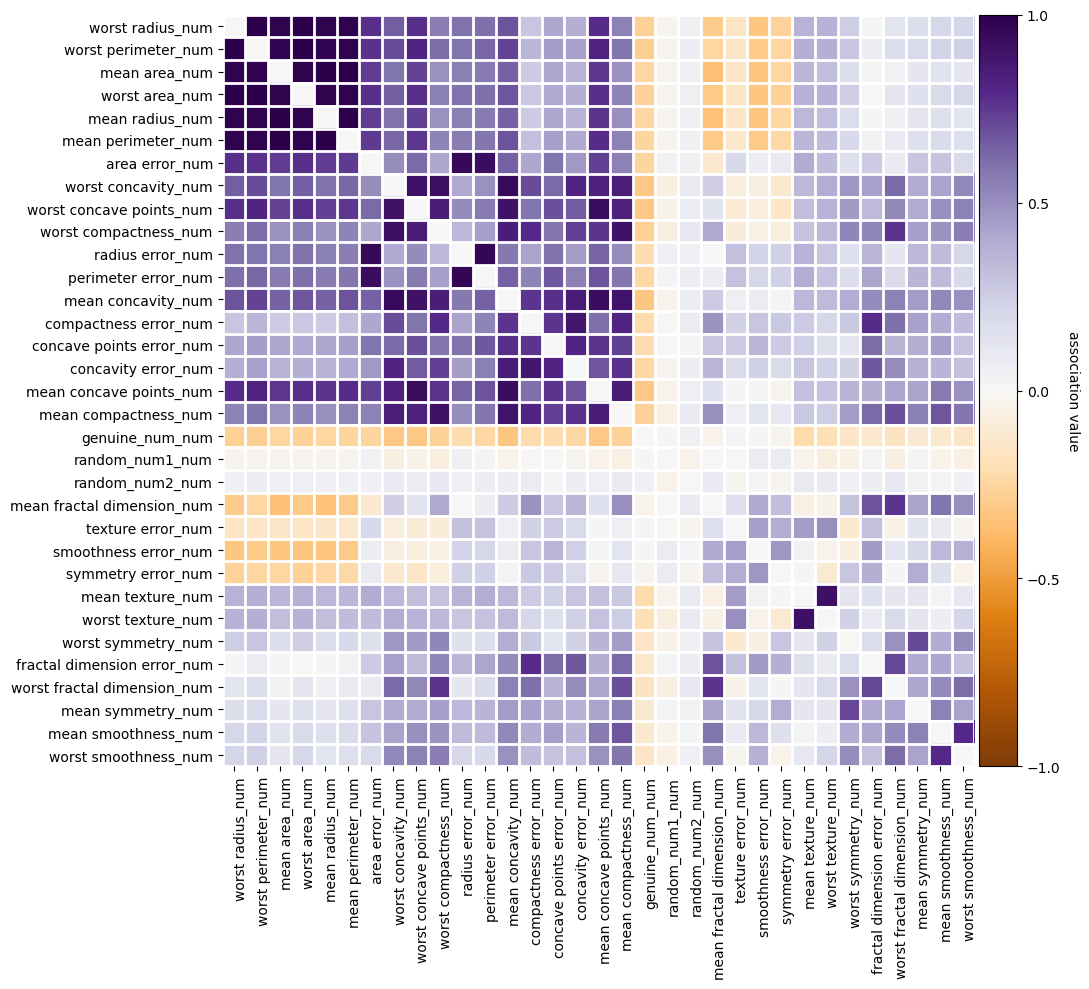

In [5]:
f = basic_fs_pipeline.named_steps["collinearity"].plot_association()

### BorutaPy

Boruta, in its "official" implementation uses gain/gini feature importance (which is known to be biased). Let's see what are the results on this data set

In [6]:
%%time

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)

# define Boruta feature selection method
bp_feat_selector = BorutaPy(rf, n_estimators="auto", verbose=1, random_state=1)

# find all relevant features - 5 features should be selected
bp_feat_selector.fit(X_filtered.values, y.values)

# check selected features - first 5 features are selected
print("\n")
print(list(X_filtered.columns[bp_feat_selector.support_]))

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100


BorutaPy finished running.

Iteration: 	23 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	2


['mean texture', 'mean area', 'texture error', 'smoothness error', 'symmetry error', 'worst smoothness', 'genuine_num']
CPU times: total: 8.89 s
Wall time: 5.71 s


### Leshy

Let's compare to the official python implementation, using the same setting and the gini/gain feature importance. We should have the same results (btw, you can check the unit tests, BorutaPy is used as baseline).

Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 100
Confirmed: 	7
Tentative: 	0
Rejected: 	2
All relevant predictors selected in 00:00:03.47
The selected features: ['mean texture' 'mean area' 'texture error' 'smoothness error'
 'symmetry error' 'worst smoothness' 'genuine_num']
The agnostic ranking: [1 1 1 1 1 1 2 3 1]
The naive ranking: ['mean area', 'mean texture', 'worst smoothness', 'genuine_num', 'smoothness error', 'texture error', 'symmetry error', 'random_num1', 'random_num2']


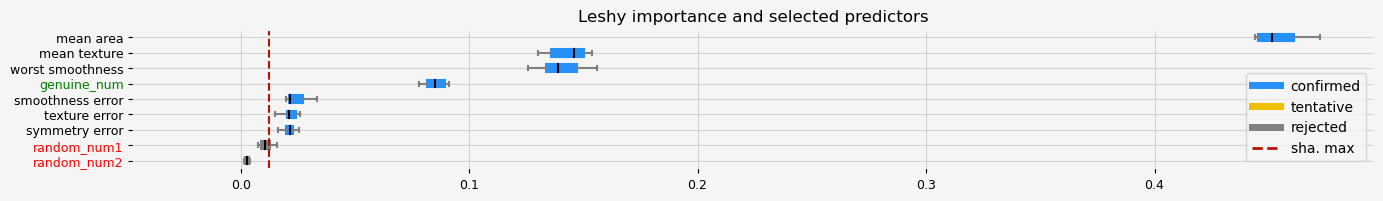

CPU times: total: 5.39 s
Wall time: 3.9 s


In [7]:
%%time
# Leshy, all the predictors, no-preprocessing
model = clone(rf)

leshy_feat_selector = arfsgroot.Leshy(
    rf,
    n_estimators="auto",
    verbose=1,
    max_iter=100,
    random_state=1,
    importance="native",
)
leshy_feat_selector.fit(X_filtered, y, sample_weight=None)
print(f"The selected features: {leshy_feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {leshy_feat_selector.ranking_}")
print(f"The naive ranking: {leshy_feat_selector.ranking_absolutes_}")
fig = leshy_feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

### Same Results?

In [8]:
def check_list_equal(L1, L2):
    return len(L1) == len(L2) and sorted(L1) == sorted(L2)

In [9]:
check_list_equal(
    leshy_feat_selector.get_feature_names_out(),
    list(X_filtered.columns[bp_feat_selector.support_]),
)

True

### BorutaShap with native importance

BorutaShap, is an alternative implementation (heavy re-writting and new material) of Boruta with Shap feature importance. Let's see what are the results on this data set

In [10]:
%%time

from BorutaShap import BorutaShap
from arfs.preprocessing import OrdinalEncoderPandas

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
model = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)

# define BorutaShap feature selection method (doesn't convert automatically cat feature)
X_encoded = OrdinalEncoderPandas().fit_transform(X=X_filtered)
bs_feat_selector = BorutaShap(
    model=model, importance_measure="gini", classification=True
)

# find all relevant features - 5 features should be selected
bs_feat_selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
bs_feat_selector.plot(X_size=12, figsize=(8, 6), y_scale="log", which_features="all")

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


The `boston` dataset is imported but removed from scikit-learn, from the version >= `1.2.0`.

The `hasattr` is called before fitting so `feature_importances_` is not found. Let's use the default, which is also a random forest

In [11]:
%%time

from BorutaShap import BorutaShap

bs_feat_selector = BorutaShap(importance_measure="gini", classification=True)

# find all relevant features - 5 features should be selected
bs_feat_selector.fit(X=X_encoded, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
bs_feat_selector.plot(X_size=12, figsize=(12, 8), y_scale="log", which_features="all")

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


### Comparison with Boruta

In [ ]:
check_list_equal(
    list(X_filtered.columns[bp_feat_selector.support_]), list(bs_feat_selector.accepted)
)